<a href="https://colab.research.google.com/github/Datapark1018/LST/blob/main/LST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setting

In [1]:
# 초기 설정
!apt-get -qq install fonts-nanum  # 폰트 설치
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import display
import os

# 데이터 전처리
from datetime import datetime
import pandas as pd
import numpy as np
import random

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns

# 데이터 모델링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 데이터 프레임 열 전체 보기
pd.set_option('display.max_columns',None)

# 한글 폰트 설정
new_font = fm.FontEntry(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, new_font)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 feature 설명
columns_dict = {'ta': '평균 기온', 'td' : '이슬점 온도', 'hm' :'습도', 'ws':'평균 풍속', 'rn':'누적 강수량','re':'강수유무', 'ww':'현천', 'ts':'지표면 온도', 'si':'누적 일사량', 'ss':'누적 일조량', 'sn':'적설'}

Selecting previously unselected package fonts-nanum.
(Reading database ... 123620 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Mounted at /content/drive


# 2. EDA

## Data Overview

1. train 44만여개의 데이터로, 14개의 칼럼 존재
2. target은 지표면 온도인 숫자형 변수 'ts', 나머지 10개의 기상 제원이 주요 feature (1개 범주형 + 9개 숫자형)
3. stn은 관측소 번호, year은 연도 마스킹, mmddhh 관측시간
4. null은 없으나 실질적 결측치인 -99.9 존재

> -99.9로 표기된 결측치외에 다른 방식으로 표기된 결측치 있는지 확인하고 결측치를 보간 또는 제거 必

> 날씨는 시공간의 영향을 받는 요소 이므로 datetime 타입의 날짜를 추가하고, 관측소 위치에 따른 영향 체크 必.

In [2]:
train = pd.read_csv('drive/MyDrive/Projects/LST/data/train.csv', dtype={"mmddhh":str})
test = pd.read_csv('drive/MyDrive/Projects/LST/data/test.csv', dtype={"mmddhh":str})

display(train.head(3))
print(f"\n{'➖'*50}\n")
display(columns_dict)
print(f"\n{'➖'*50}\n")
display(train.info())
print(f"\n{'➖'*50}\n")
display(train.isnull().sum().to_frame().T)


,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,ts,si,ss,sn
0,1,A,020100,-9.9,-10.7,93.9,0.6,0.0,0,H,-1.3,-99.9,-99.9,-99.9
1,1,A,020101,-10.8,-11.6,93.8,0.6,0.0,0,H,-1.5,-99.9,-99.9,-99.9
2,1,A,020102,-11.4,-12.1,94.6,0.7,0.0,0,H,-1.7,-99.9,-99.9,-99.9



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖



{'ta': '평균 기온',
 'td': '이슬점 온도',
 'hm': '습도',
 'ws': '평균 풍속',
 'rn': '누적 강수량',
 're': '강수유무',
 'ww': '현천',
 'ts': '지표면 온도',
 'si': '누적 일사량',
 'ss': '누적 일조량',
 'sn': '적설'}


➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438240 entries, 0 to 438239
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stn     438240 non-null  int64  
 1   year    438240 non-null  object 
 2   mmddhh  438240 non-null  object 
 3   ta      438240 non-null  float64
 4   td      438240 non-null  float64
 5   hm      438240 non-null  float64
 6   ws      438240 non-null  float64
 7   rn      438240 non-null  float64
 8   re      438240 non-null  int64  
 9   ww      438240 non-null  object 
 10  ts      438240 non-null  float64
 11  si      438240 non-null  float64
 12  ss      438240 non-null  float64
 13  sn      438240 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 46.8+ MB


None


➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖



,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,ts,si,ss,sn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocessing

**Details about 'ww'**
> C : 맑음 | H : 박무 | R : 비 | G : 연무 | X : 모름 | F : 안개 | S : 눈

**'ta'는 target이므로** 결측치가 있는 행 모두 제거

In [3]:
display(train.min().to_frame().T)
display(train['ww'].value_counts().to_frame().T)

print(f"결측치 {train[train['ta'] == -99.9].shape[0]} 개 제거")
train = train[train['ta'] != -99.9]

# 시간날짜 생성
train['date'] = pd.to_datetime([str(2017 + ord(x) - ord("A")) for x in train['year']] + train['mmddhh'], format="%Y%m%d%H")

,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,ts,si,ss,sn
0,1,A,010100,-99.9,-99.9,-99.9,-99.9,-99.9,-99,C,-99.9,-99.9,-99.9,-99.9


ww,C,H,R,G,X,F,S
count,290265,58793,49177,30100,3514,3499,2892


결측치 630 개 제거


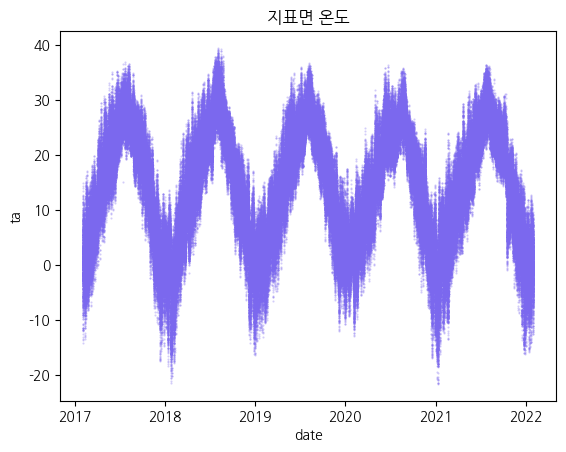

In [4]:
train.plot.scatter(x='date', y='ta', s=0.3, alpha=0.3, color='mediumslateblue', title="지표면 온도")
plt.show()